In [20]:
import copy
import numpy as np
import konrad

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange, tqdm

import itertools
import multiprocessing

In [21]:
#
# Used in examples below
#
atmosphere = konrad.atmosphere.Atmosphere(konrad.utils.get_quadratic_pgrid(1000e2, 10, 128))
atmosphere["CO2"][:] = 280E-6
initial_conds = atmosphere.copy()

### Example: storing RCE solutions for varying surface T, relative humidity

In [22]:
def make_key(T = 294, RH = 0.8): 
    return(f'{T}K_{RH*100}%') 

In [23]:
Tss = [273, 288, 294, 300, 305]
RHs = [.1, .25, .5, .75, .9]

In [24]:
%%time
rces = {}

for Ts in Tss:
    for RH in RHs: 
        k = make_key(T=Ts, RH=RH)
        rces[k] = konrad.RCE(initial_conds.copy(), 
                             surface=konrad.surface.FixedTemperature(temperature=Ts), 
                             humidity=konrad.humidity.FixedRH(konrad.humidity.VerticallyUniform(RH)), 
        ) 

for k in tqdm(rces.keys()): 
    rces[k].run()

  0%|          | 0/25 [00:00<?, ?it/s]

CPU times: user 7min 59s, sys: 680 ms, total: 8min
Wall time: 7min 59s


### Using multiprocessing, thanks to Lukas Kluft

In [25]:
def run_rce(Ts=300., RH=0.8):
    """Run an RCE for a given combination of Ts and RH."""
    rce = konrad.RCE(
        atmosphere=konrad.atmosphere.Atmosphere(konrad.utils.get_quadratic_pgrid(num=64)),
        surface=konrad.surface.FixedTemperature(temperature=Ts), 
        humidity=konrad.humidity.FixedRH(konrad.humidity.VerticallyUniform(RH)), 
    )
    rce.run()
    
    return rce

In [32]:
rce_configs = list(itertools.product(Tss, RHs))

In [31]:
%%time
# Run processes in parallel
with multiprocessing.Pool(processes=4) as pool:
    rce_results = pool.starmap(run_rce, rce_configs)

CPU times: user 517 ms, sys: 275 ms, total: 792 ms
Wall time: 4min


In [28]:
rces = dict(zip(rce_configs, rce_results))
rces.keys()

dict_keys([(273, 0.1), (273, 0.25), (273, 0.5), (273, 0.75), (273, 0.9), (288, 0.1), (288, 0.25), (288, 0.5), (288, 0.75), (288, 0.9), (294, 0.1), (294, 0.25), (294, 0.5), (294, 0.75), (294, 0.9), (300, 0.1), (300, 0.25), (300, 0.5), (300, 0.75), (300, 0.9), (305, 0.1), (305, 0.25), (305, 0.5), (305, 0.75), (305, 0.9)])

The results are now in a dictionary, the keys of which are tupules of T, RH, i.e. (273, 0.25). 

Use these to make a plot of vertical structure... 

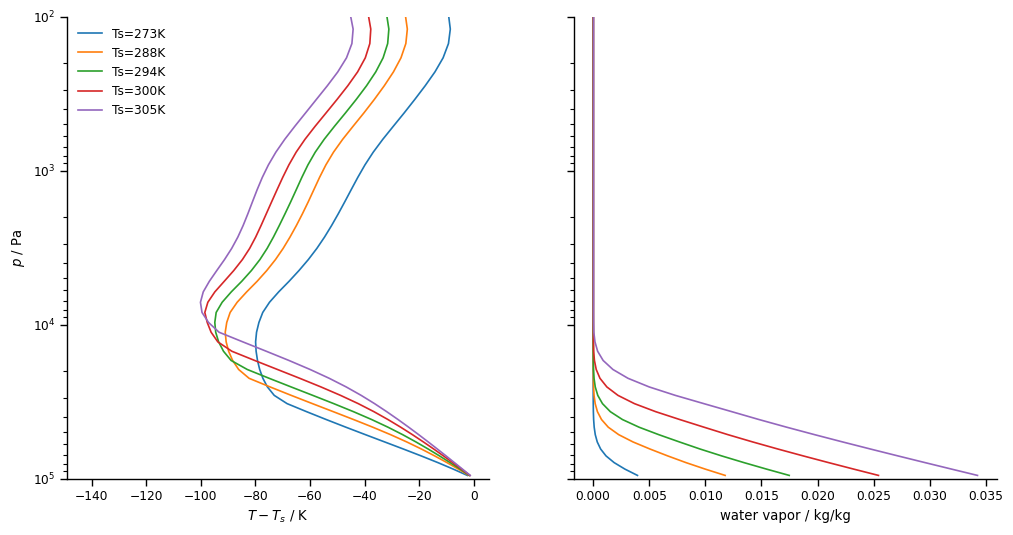

In [29]:
sns.set_context("paper")
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=[12, 6], sharey=True)

# Vary temperature at fixed RH = 80%
RH = 0.75
assert (RH in RHs) 
for Ts in Tss:
    ax0.semilogy(rces[(Ts, RH)].atmosphere['T'  ][0,:] - Ts, 
                 rces[(Ts, RH)].atmosphere['plev'], label = "Ts="+str(Ts)+"K")
    ax1.semilogy(rces[(Ts, RH)].atmosphere['H2O'][0,:], 
                 rces[(Ts, RH)].atmosphere['plev'])
    

ax0.set_ylim(rces[(Ts, RH)].atmosphere["phlev"][0], 100.) 
ax0.set_ylabel("$p$ / Pa")
ax0.set_xlabel("$T - T_s$ / K")
ax0.legend(frameon = False)

ax1.set_xlabel("water vapor / kg/kg")

sns.despine() 
fig.savefig("State-profiles-vs-T.pdf")